In [2]:
# -----------------------------
# Install & Imports (Colab)
# -----------------------------
!pip install qiskit qiskit-aer --quiet

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_city, plot_histogram
import numpy as np
import matplotlib.pyplot as plt

sim = AerSimulator()
shots = 1024


# TASK A: Predict the statevector after H

In [3]:
# ============================================
# TASK A: Predict the statevector after H on:
# |0>, |1>, |+>, |->
# ============================================
sqrt2 = np.sqrt(2)

# Analytical predictions:
# H|0>  = (|0> + |1>) / sqrt(2)  => [1/sqrt(2), 1/sqrt(2)]
# H|1>  = (|0> - |1>) / sqrt(2)  => [1/sqrt(2), -1/sqrt(2)]
# H|+>  = H(H|0>) = |0>            => [1, 0]
# H|->  = H(H|1>) = |1>            => [0, 1]

predictions = {
    "H|0>": np.array([1/sqrt2, 1/sqrt2]),
    "H|1>": np.array([1/sqrt2, -1/sqrt2]),
    "H|+>": np.array([1.0, 0.0]),
    "H|->": np.array([0.0, 1.0]),
}

print("Analytical predictions (statevectors):")
for k, v in predictions.items():
    print(f"{k}: {np.round(v, 6)}")
print("\n")


Analytical predictions (statevectors):
H|0>: [0.707107 0.707107]
H|1>: [ 0.707107 -0.707107]
H|+>: [1. 0.]
H|->: [0. 1.]




--- |0> ---
Statevector (simulated): [0.707107+0.j 0.707107+0.j]


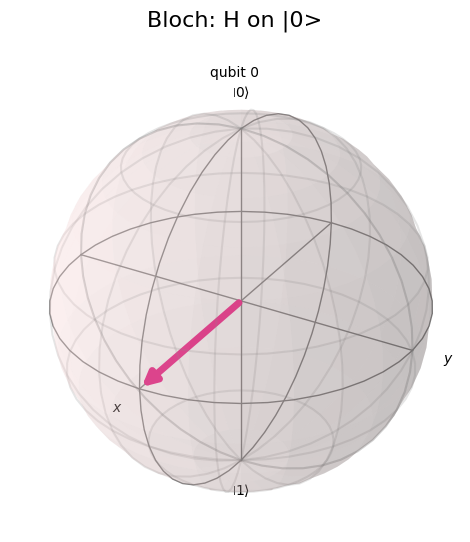

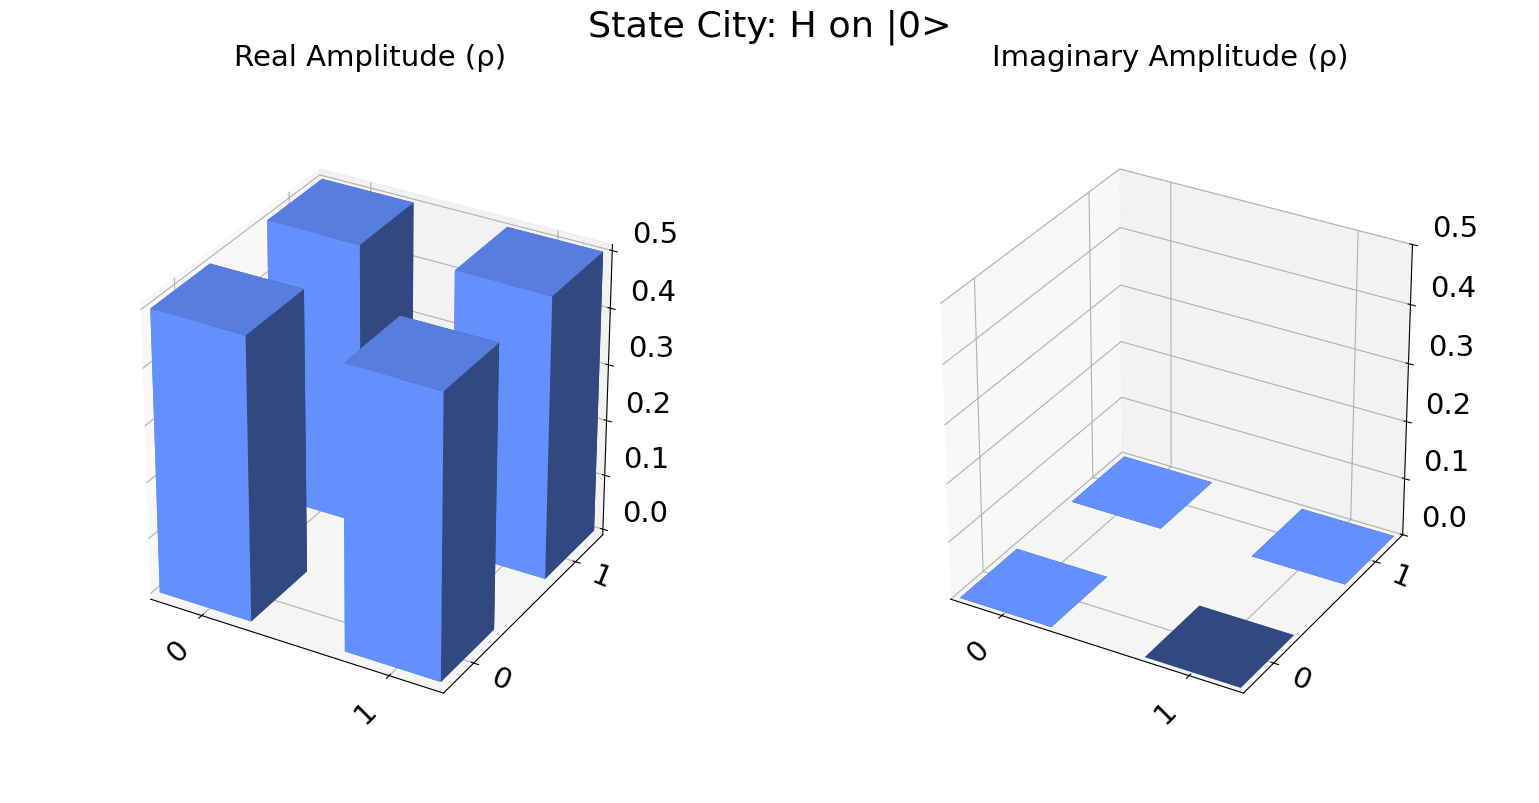

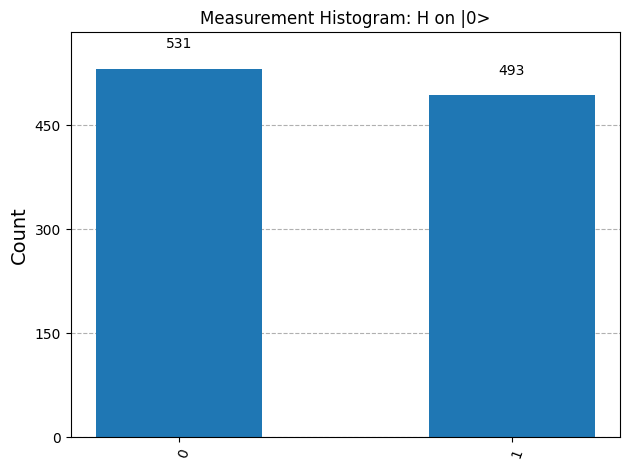

Counts: {'1': 493, '0': 531} 

--- |1> ---
Statevector (simulated): [ 0.707107+0.j -0.707107+0.j]


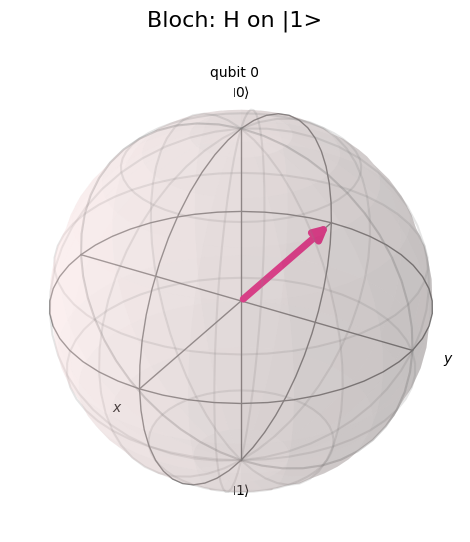

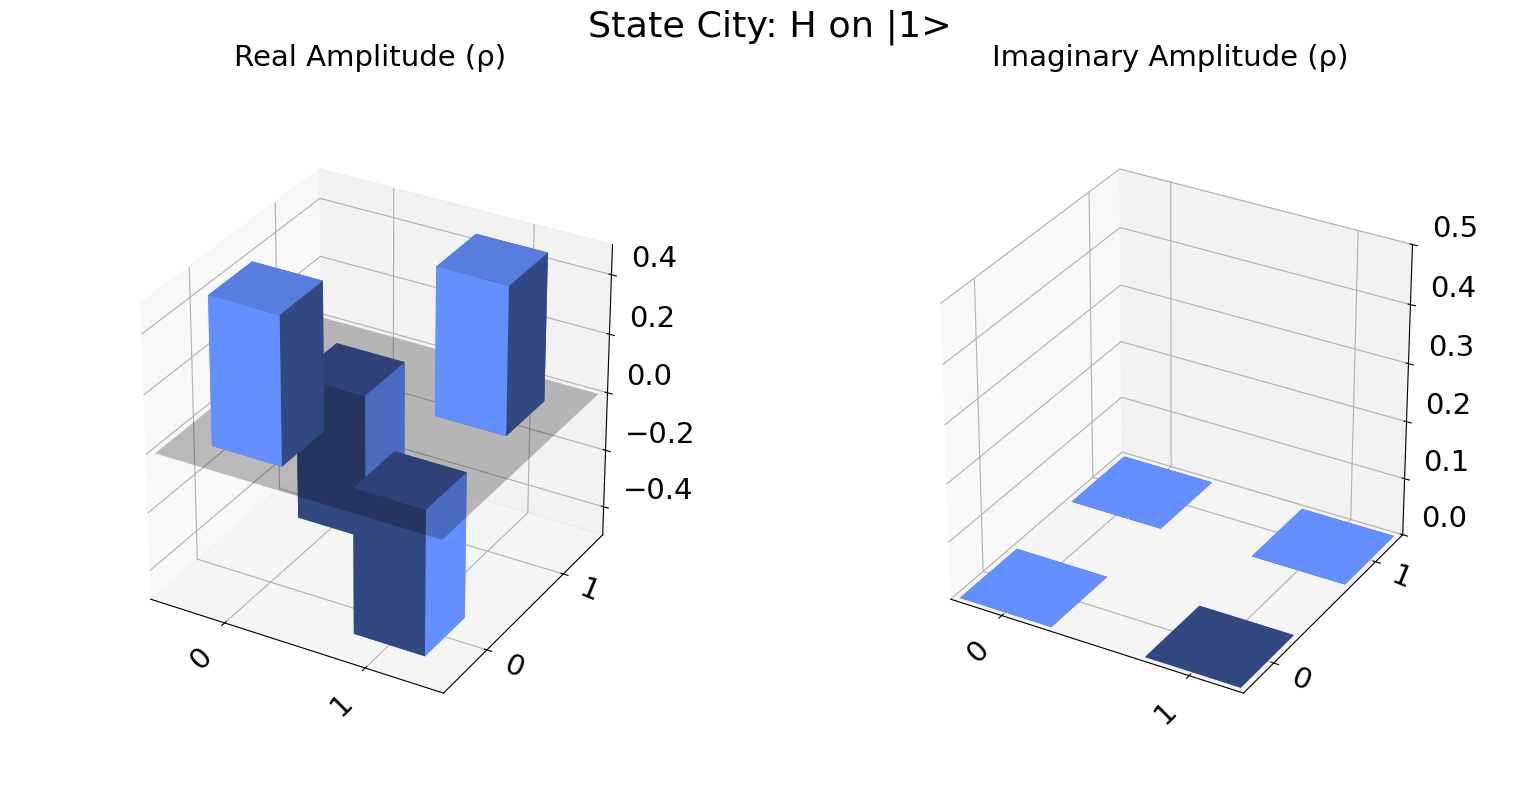

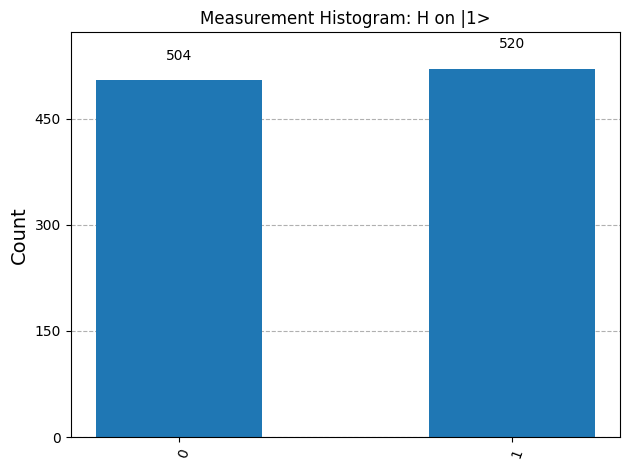

Counts: {'1': 520, '0': 504} 

--- |+> ---
Statevector (simulated): [1.+0.j 0.+0.j]


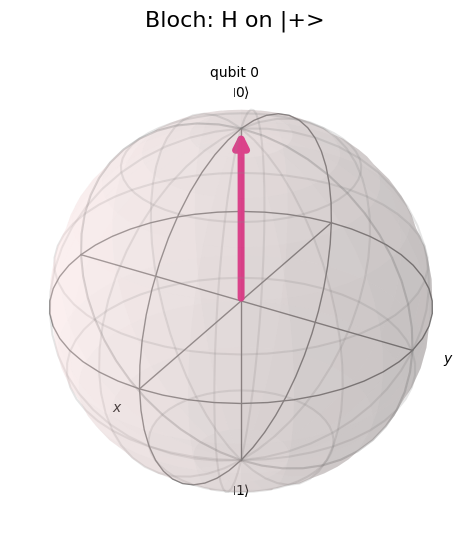

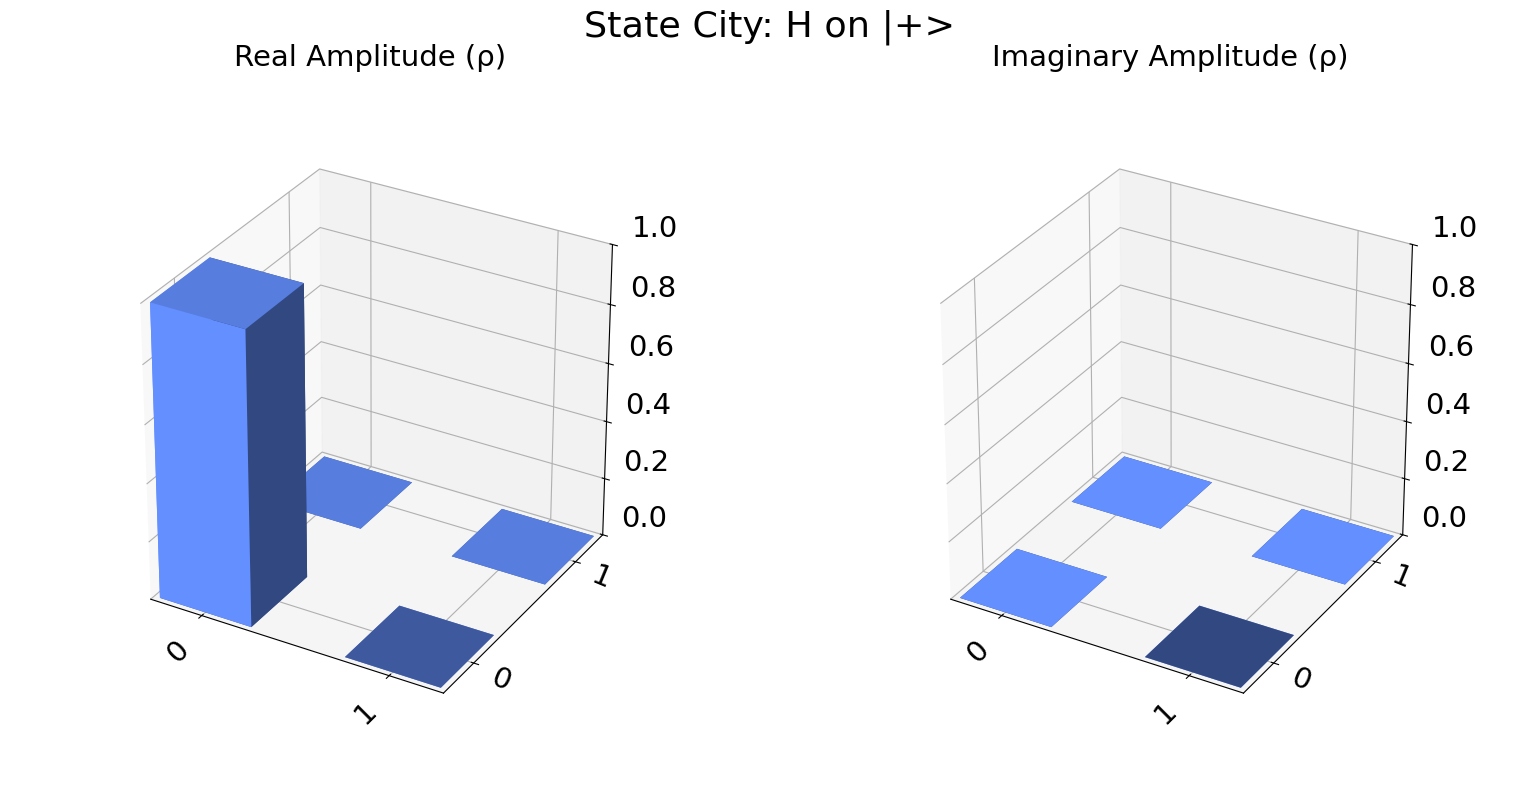

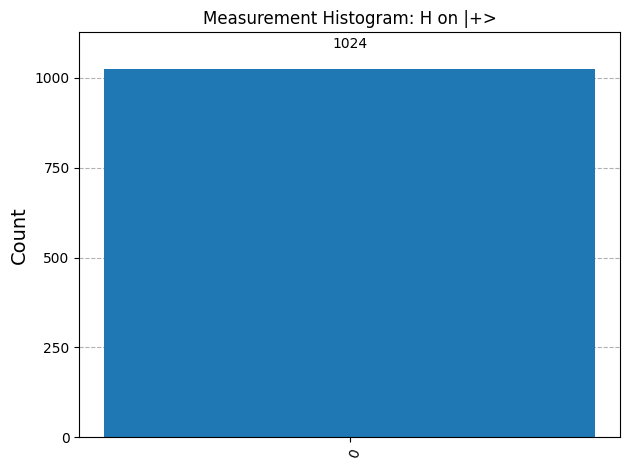

Counts: {'0': 1024} 

--- |-> ---
Statevector (simulated): [0.+0.j 1.+0.j]


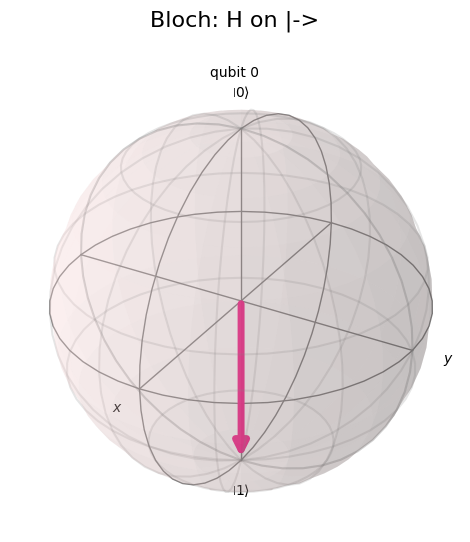

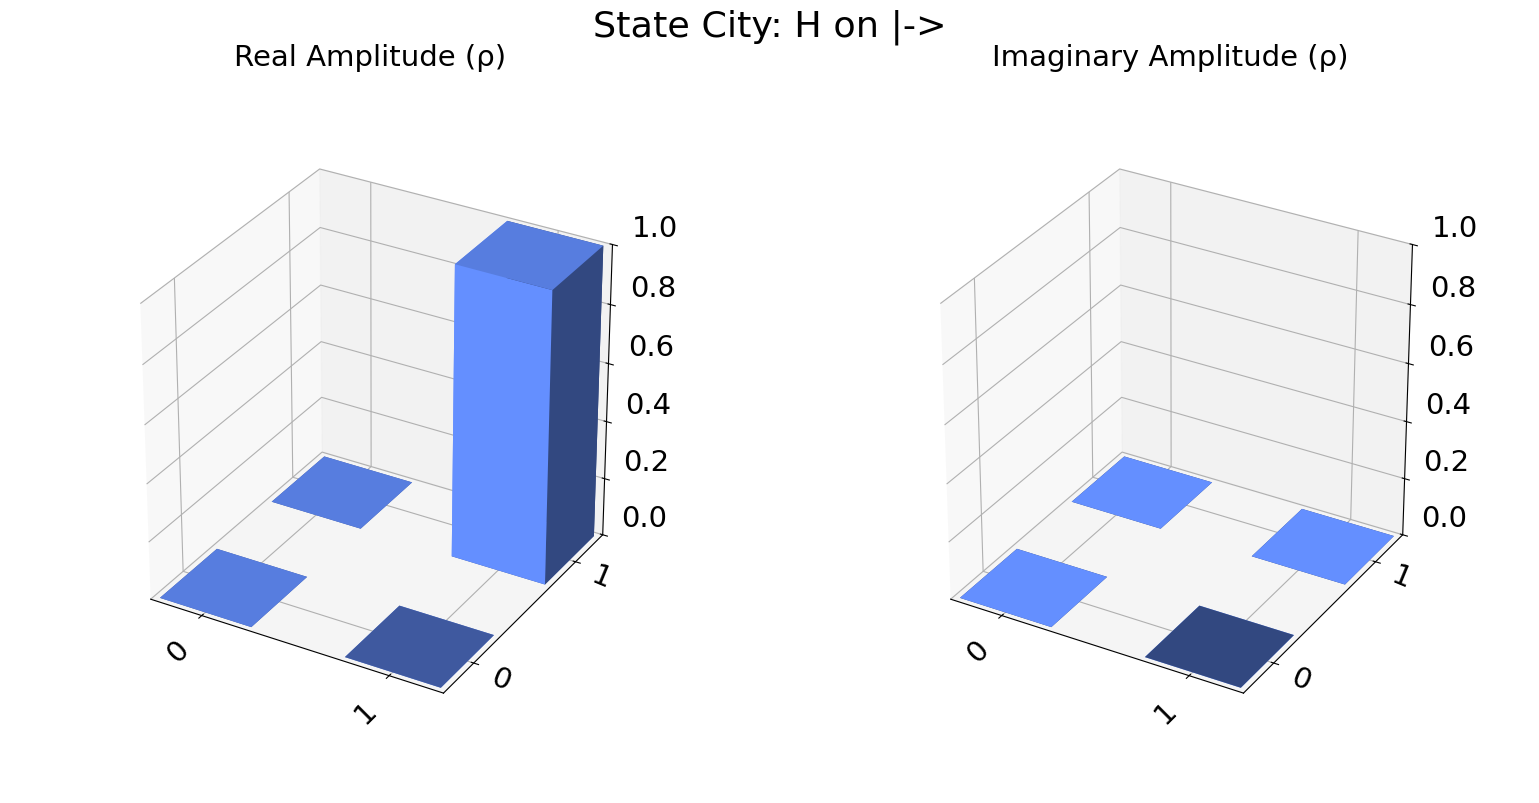

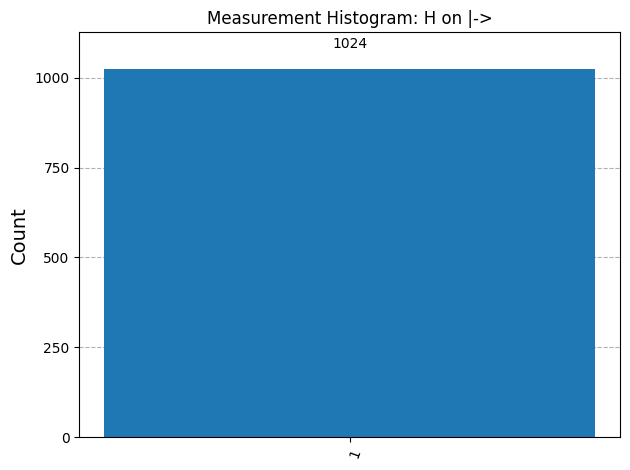

Counts: {'1': 1024} 



In [4]:
# Run circuits to confirm predictions and visualize on Bloch sphere
def run_and_visualize(init_state, label):
    # Build circuit for statevector & measurement
    qc = QuantumCircuit(1, 1)
    qc.initialize(init_state, 0)
    qc.h(0)
    qc.measure(0, 0)

    qc_state = QuantumCircuit(1)
    qc_state.initialize(init_state, 0)
    qc_state.h(0)
    state_after = Statevector.from_instruction(qc_state)

    print(f"--- {label} ---")
    print("Statevector (simulated):", np.round(state_after.data, 6))

    # Bloch and state city
    display(plot_bloch_multivector(state_after, title=f"Bloch: H on {label}"))
    display(plot_state_city(state_after, title=f"State City: H on {label}"))

    # simulate measurements
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=shots).result()
    counts = result.get_counts()
    display(plot_histogram(counts, title=f"Measurement Histogram: H on {label}"))
    print("Counts:", counts, "\n")

# |0>
run_and_visualize(np.array([1, 0]), "|0>")

# |1>
run_and_visualize(np.array([0, 1]), "|1>")

# |+> = (|0> + |1>)/sqrt(2)
run_and_visualize(np.array([1/sqrt2, 1/sqrt2]), "|+>")

# |-> = (|0> - |1>)/sqrt(2)
run_and_visualize(np.array([1/sqrt2, -1/sqrt2]), "|->")


# TASK B: 3-qubit system H⊗H⊗H on |000>

--- 3-qubit H⊗H⊗H on |000> ---
Statevector (first 8 amplitudes): [0.353553+0.j 0.353553+0.j 0.353553+0.j 0.353553+0.j 0.353553+0.j
 0.353553+0.j 0.353553+0.j 0.353553+0.j]


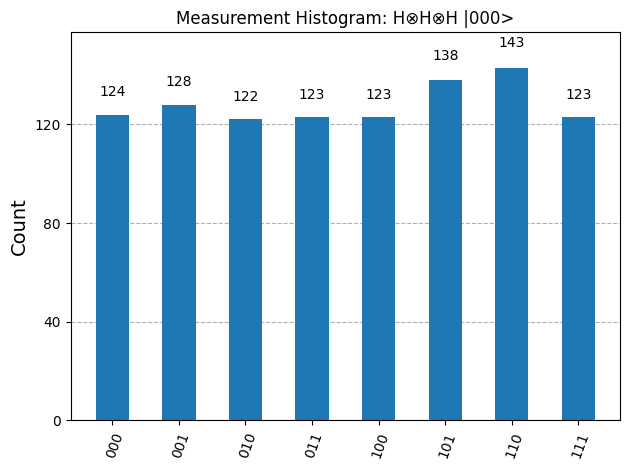

Counts (expected ~1/8 each): {'100': 123, '110': 143, '111': 123, '011': 123, '001': 128, '101': 138, '010': 122, '000': 124}



In [5]:
# ============================================
# TASK B: 3-qubit system H⊗H⊗H on |000>
# Prediction:
# H⊗H⊗H |000> = sum_{b in {0,1}^3} (1/√8) |b>
# => each of 8 basis states has probability 1/8.
# ============================================
qc3 = QuantumCircuit(3, 3)
qc3.h([0,1,2])
qc3.measure([0,1,2], [0,1,2])

# Statevector before measurement
qc3_state = QuantumCircuit(3)
qc3_state.h([0,1,2])
state3 = Statevector.from_instruction(qc3_state)
print("--- 3-qubit H⊗H⊗H on |000> ---")
print("Statevector (first 8 amplitudes):", np.round(state3.data, 6))

# histogram
compiled = transpile(qc3, sim)
result = sim.run(compiled, shots=shots).result()
counts3 = result.get_counts()
display(plot_histogram(counts3, title="Measurement Histogram: H⊗H⊗H |000>"))
print("Counts (expected ~1/8 each):", counts3)
print()


# TASK C: H + CX + CX on 3 qubits (GHZ-like)

--- GHZ-like state (H + CX + CX) ---
Statevector: [0.707107+0.j 0.      +0.j 0.      +0.j 0.      +0.j 0.      +0.j
 0.      +0.j 0.      +0.j 0.707107+0.j]


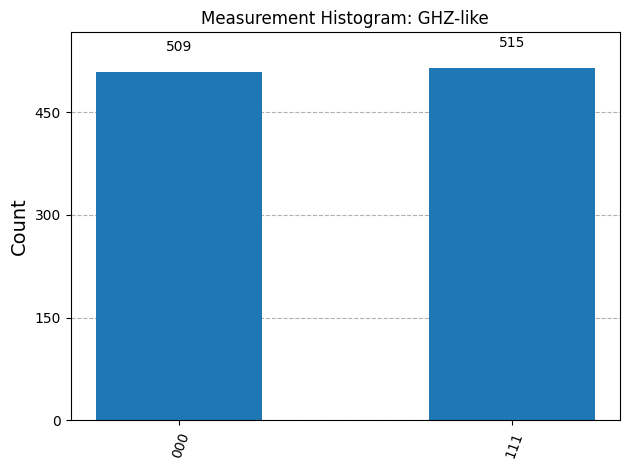

Counts (expected mostly '000' and '111'): {'111': 515, '000': 509}



In [6]:
# ============================================
# TASK C: H + CX + CX on 3 qubits (GHZ-like)
# Circuit (common pattern):
# - Apply H on qubit 0
# - CNOT with control 0 -> target 1
# - CNOT with control 0 -> target 2
# Prediction: (|000> + |111>)/√2  -> only outcomes 000 and 111 (perfectly correlated)
# ============================================
qc_ghz = QuantumCircuit(3, 3)
qc_ghz.h(0)
qc_ghz.cx(0, 1)
qc_ghz.cx(0, 2)
qc_ghz.measure([0,1,2], [0,1,2])

qc_ghz_state = QuantumCircuit(3)
qc_ghz_state.h(0)
qc_ghz_state.cx(0,1)
qc_ghz_state.cx(0,2)
state_ghz = Statevector.from_instruction(qc_ghz_state)

print("--- GHZ-like state (H + CX + CX) ---")
print("Statevector:", np.round(state_ghz.data, 6))  # expect amplitudes at indices 0 and 7

# simulate
compiled = transpile(qc_ghz, sim)
result = sim.run(compiled, shots=shots).result()
counts_ghz = result.get_counts()
display(plot_histogram(counts_ghz, title="Measurement Histogram: GHZ-like"))
print("Counts (expected mostly '000' and '111'):", counts_ghz)
print()


# TASK D: Apply H twice on |1> and verify return to |1>

--- H twice on |1> ---
Statevector after H,H on |1>: [0.+0.j 1.+0.j]


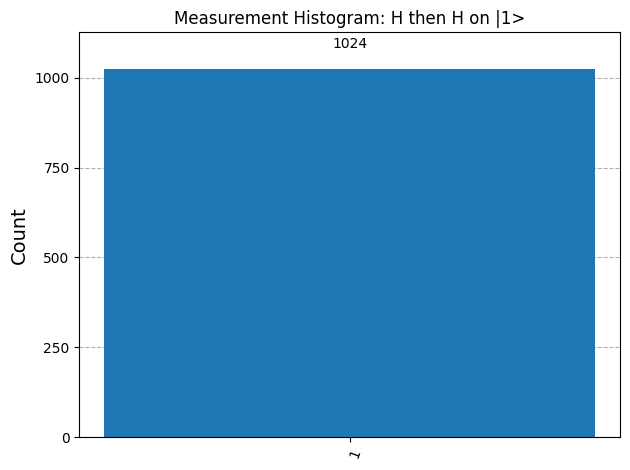

Counts (expect mostly '1'): {'1': 1024}



In [7]:
# ============================================
# TASK D: Apply H twice on |1> and verify return to |1>
# Analytical: H^2 = I, so H(H|1>) = |1>
# ============================================
qc_h2 = QuantumCircuit(1,1)
qc_h2.initialize([0,1], 0)  # |1>
qc_h2.h(0)
qc_h2.h(0)
qc_h2.measure(0,0)

qc_h2_state = QuantumCircuit(1)
qc_h2_state.initialize([0,1], 0)
qc_h2_state.h(0)
qc_h2_state.h(0)
state_h2 = Statevector.from_instruction(qc_h2_state)

print("--- H twice on |1> ---")
print("Statevector after H,H on |1>:", np.round(state_h2.data, 6))
# Expect [0, 1]
compiled = transpile(qc_h2, sim)
result = sim.run(compiled, shots=shots).result()
counts_h2 = result.get_counts()
display(plot_histogram(counts_h2, title="Measurement Histogram: H then H on |1>"))
print("Counts (expect mostly '1'):", counts_h2)
print()


# TASK E: Bloch sphere observations of Hadamard rotations

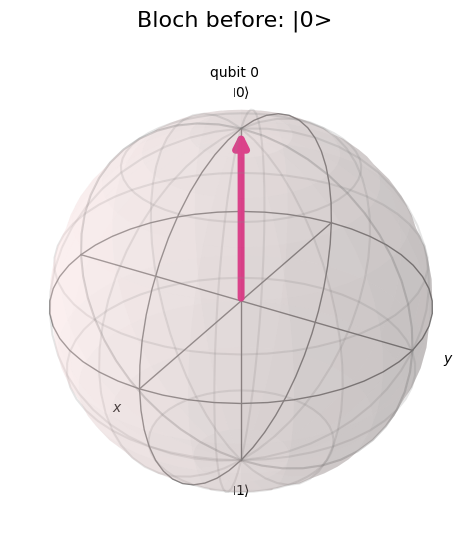

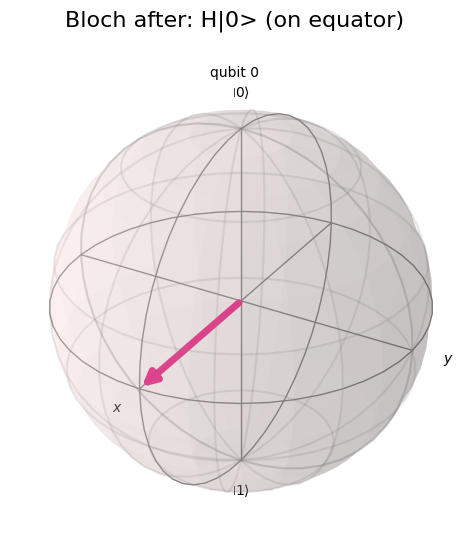

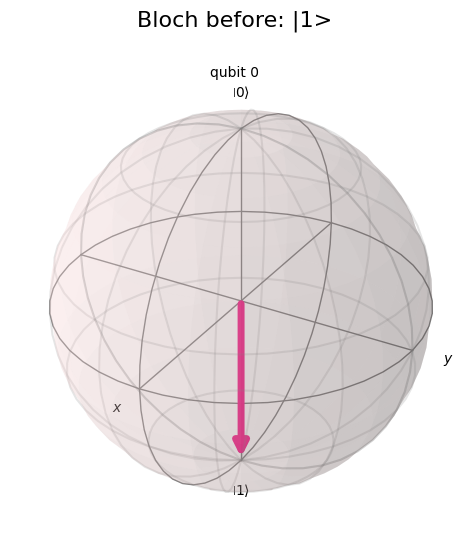

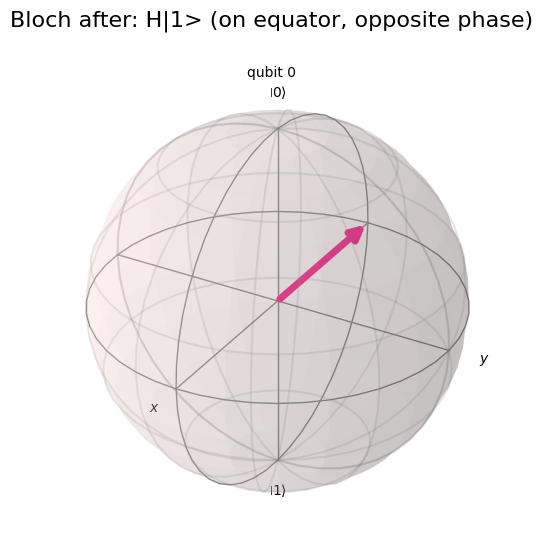

In [8]:
# ============================================
# TASK E: Bloch sphere observations of Hadamard rotations
# - Show Bloch vector for |0> before and after H
# ============================================
# Before: |0>
state_before = Statevector.from_label('0')
display(plot_bloch_multivector(state_before, title="Bloch before: |0>"))

# After H:
qc_tmp = QuantumCircuit(1)
qc_tmp.h(0)
state_after_h = Statevector.from_instruction(qc_tmp)
display(plot_bloch_multivector(state_after_h, title="Bloch after: H|0> (on equator)"))

# Also visualize H on |1>
state1_before = Statevector.from_label('1')
display(plot_bloch_multivector(state1_before, title="Bloch before: |1>"))
qc_tmp2 = QuantumCircuit(1)
qc_tmp2.h(0)
qc_tmp2.initialize([0,1], 0)  # start |1> then H
qc_tmp2.h(0)
state1_after = Statevector.from_instruction(qc_tmp2)
display(plot_bloch_multivector(state1_after, title="Bloch after: H|1> (on equator, opposite phase)"))
